# Semi-supervised Learning

* Preparing and executing partially and delayed labeling experiments

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 25/07/2024**

In [1]:
from capymoa.stream import stream_from_file
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_ssl_evaluation
from capymoa.datasets import Electricity

## 1. Learning using a SSL classifier

* This example uses the OSNN algorithm to learn from a stream with only 1% labeled data
* We utilize the `prequential_ssl_evaluation()` function to simulate the absence of labels (`label_probability`) and delays (`delay_length`)
* The results yield by `prequential_ssl_evaluation()` include more information in comparison to `prequential_evaluation()`, such as the number of unlabeled instances (`unlabeled`) and the unlabeled ratio (`unlabeled_ratio`). 

In [2]:
help(prequential_ssl_evaluation)

Help on function prequential_ssl_evaluation in module capymoa.evaluation.evaluation:

prequential_ssl_evaluation(stream, learner, max_instances=None, window_size=1000, initial_window_size=0, delay_length=0, label_probability=0.01, random_seed=1, store_predictions=False, store_y=False, optimise=True)
    If the learner is not an SSL learner, then it will be trained only on the labeled instances.



59.3


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,62.0,-23.136747,-216.666667,-2.702703,38.271605,NaN,76.543210,37.349398,0.000000,74.698795,39.240506,0.000000,78.481013
3,400.0,63.0,3.242678,-236.363636,44.776119,62.922136,77.018634,5.128205,81.313131,62.626263,100.000000,51.315789,100.000000,2.631579
4,500.0,45.0,-4.009077,-358.333333,-5.769231,31.034483,62.068966,NaN,22.959184,45.918367,0.000000,47.872340,95.744681,0.000000
5,600.0,47.0,6.952247,-278.571429,-51.428571,55.070599,54.700855,36.144578,55.967450,40.506329,71.428571,54.202037,84.210526,24.193548
6,700.0,57.0,2.890696,-138.888889,14.000000,51.548932,68.613139,31.746032,51.754386,61.842105,41.666667,51.345103,77.049180,25.641026
7,800.0,78.0,54.337900,-29.411765,48.837209,77.384628,81.666667,72.500000,78.078078,77.777778,78.378378,76.703386,85.964912,67.441860
8,900.0,58.0,17.808219,-121.052632,22.222222,59.376801,55.319149,60.377358,59.562842,66.666667,52.459016,59.191919,47.272727,71.111111
9,1000.0,84.0,67.793881,-100.000000,68.000000,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696,83.896940,85.185185,82.608696


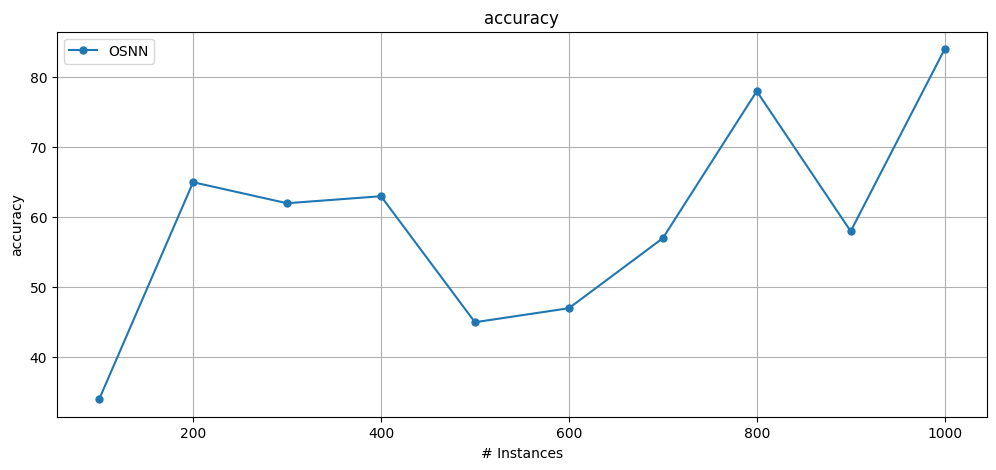

In [3]:
from capymoa.ssl.classifier import OSNN

stream = Electricity()

osnn = OSNN(schema=stream.get_schema())

results_osnn = prequential_ssl_evaluation(stream=stream, learner=osnn, label_probability=0.01, window_size=100, max_instances=1000)

# The results are stored in a dictionary. 
display(results_osnn)

print(results_osnn['cumulative'].accuracy()) # Test-then-train accuracy, i.e. cumulatively, not windowed. 
display(results_osnn['windowed'].metrics_per_window()) # A dataframe containing the windowed results. 

# Plotting over time (default: classifications correct (percent) i.e. accuracy)
results_osnn.learner = "OSNN"
plot_windowed_results(results_osnn, metric='accuracy')

## 1.1 Using a supervised model

* If a supervised model is used with `prequential_ssl_evaluation()` it will only be trained on the labeled data



In [4]:
from capymoa.classifier import StreamingRandomPatches

srp10 = StreamingRandomPatches(schema=stream.get_schema(), ensemble_size=10)

results_srp10 = prequential_ssl_evaluation(stream=stream, learner=srp10, label_probability=0.01, window_size=100, max_instances=1000)

print(results_srp10['cumulative'].accuracy())
display(results_srp10['windowed'].metrics_per_window())

47.199999999999996


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,100.0,34.0,0.000000,-340.000000,-112.903226,NaN,50.746269,NaN,NaN,34.000000,NaN,50.000000,100.000000,0.000000
1,200.0,65.0,0.000000,-150.000000,41.666667,NaN,78.787879,NaN,NaN,65.000000,NaN,50.000000,100.000000,0.000000
2,300.0,21.0,0.000000,-558.333333,-113.513514,NaN,34.710744,NaN,NaN,21.000000,NaN,50.000000,100.000000,0.000000
3,400.0,62.0,0.000000,-245.454545,43.283582,NaN,76.543210,NaN,NaN,62.000000,NaN,50.000000,100.000000,0.000000
4,500.0,50.0,5.338887,-316.666667,3.846154,61.726883,65.277778,10.714286,74.226804,48.453608,100.000000,52.830189,100.000000,5.660377
5,600.0,38.0,-7.489598,-342.857143,-77.142857,44.007051,48.333333,22.500000,42.682927,35.365854,50.000000,45.415959,76.315789,14.516129
6,700.0,26.0,-39.992433,-311.111111,-48.000000,27.554157,24.489796,27.450980,27.327327,32.432432,22.222222,27.784784,19.672131,35.897436
7,800.0,62.0,13.043478,-123.529412,11.627907,65.753425,75.000000,20.833333,80.000000,60.000000,100.000000,55.813953,100.000000,11.627907
8,900.0,59.0,10.480349,-115.789474,24.074074,60.034800,72.108844,22.641509,66.304348,57.608696,75.000000,54.848485,96.363636,13.333333
9,1000.0,55.0,2.343750,-462.500000,10.000000,61.508853,70.588235,4.255319,77.272727,54.545455,100.000000,51.086957,100.000000,2.173913


## 1.2 Comparing a SSL and supervised classifiers

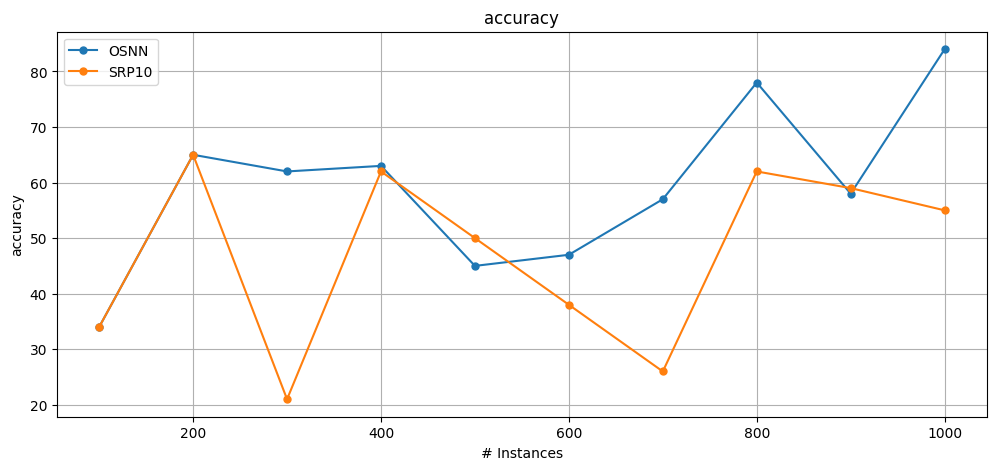

In [5]:
# Plotting all the results together
# Adding an experiment_id to the results dictionary allows controlling the legend of each learner. 
results_osnn.learner = 'OSNN'
results_srp10.learner = 'SRP10'

plot_windowed_results(results_osnn, results_srp10, metric='accuracy')

## 2. Delay example
* Comparing the effect of delay on a stream
* It is particularly interesting to see the effect after a drift takes place. 

Accuracy immediate: 86.031
Accuracy delayed by 1000 instances: 82.865


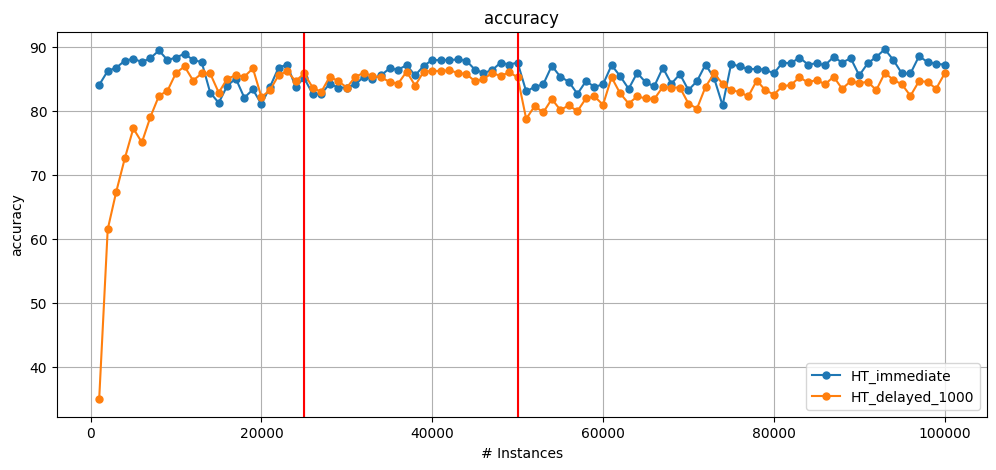

In [6]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import *
from capymoa.classifier import HoeffdingTree
from capymoa.evaluation import prequential_evaluation

## Creating a stream with drift
sea2drifts = DriftStream(stream=[SEA(function=1), 
                                 AbruptDrift(position=25000), 
                                 SEA(function=2), 
                                 AbruptDrift(position=50000), 
                                 SEA(function=3)])


ht_immediate = HoeffdingTree(schema=sea2drifts.get_schema())
ht_delayed = HoeffdingTree(schema=sea2drifts.get_schema())

results_ht_immediate = prequential_ssl_evaluation(stream=sea2drifts, 
                                                     learner=ht_immediate, 
                                                     label_probability=0.1, 
                                                     window_size=1000, 
                                                     max_instances=100000)

results_ht_delayed_1000 = prequential_ssl_evaluation(stream=sea2drifts, 
                                                       learner=ht_delayed, 
                                                       label_probability=0.01, 
                                                       delay_length=1000, # adding the delay
                                                       window_size=1000, 
                                                       max_instances=100000)

results_ht_immediate.learner = 'HT_immediate'
results_ht_delayed_1000.learner = 'HT_delayed_1000'

print(f"Accuracy immediate: {results_ht_immediate['cumulative'].accuracy()}")
print(f"Accuracy delayed by 1000 instances: {results_ht_delayed_1000['cumulative'].accuracy()}")

plot_windowed_results(results_ht_immediate, results_ht_delayed_1000, metric='accuracy')